# Build model Deep Learning with PyTorch

In [ ]:
!pip install imbalanced-learn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from imblearn.over_sampling import RandomOverSampler

import copy
import random
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## load dataset here
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Nhap mon May hoc/Mini Project/Dataset/icml_face_data.csv")
df.head()

Mounted at /content/drive


,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        # print(image)

    return image_array, image_label

In [ ]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Hiển thị hình ảnh và nhãn tương ứng (Visualize images and labels respectively)
    """
    _, axarr = plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr = axarr.flatten()
    label_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label: {} ({})".format(label, label_names[label])) # Label : 0 (Angry)

In [ ]:
## parsing data here
images, labels = parse_data(df)

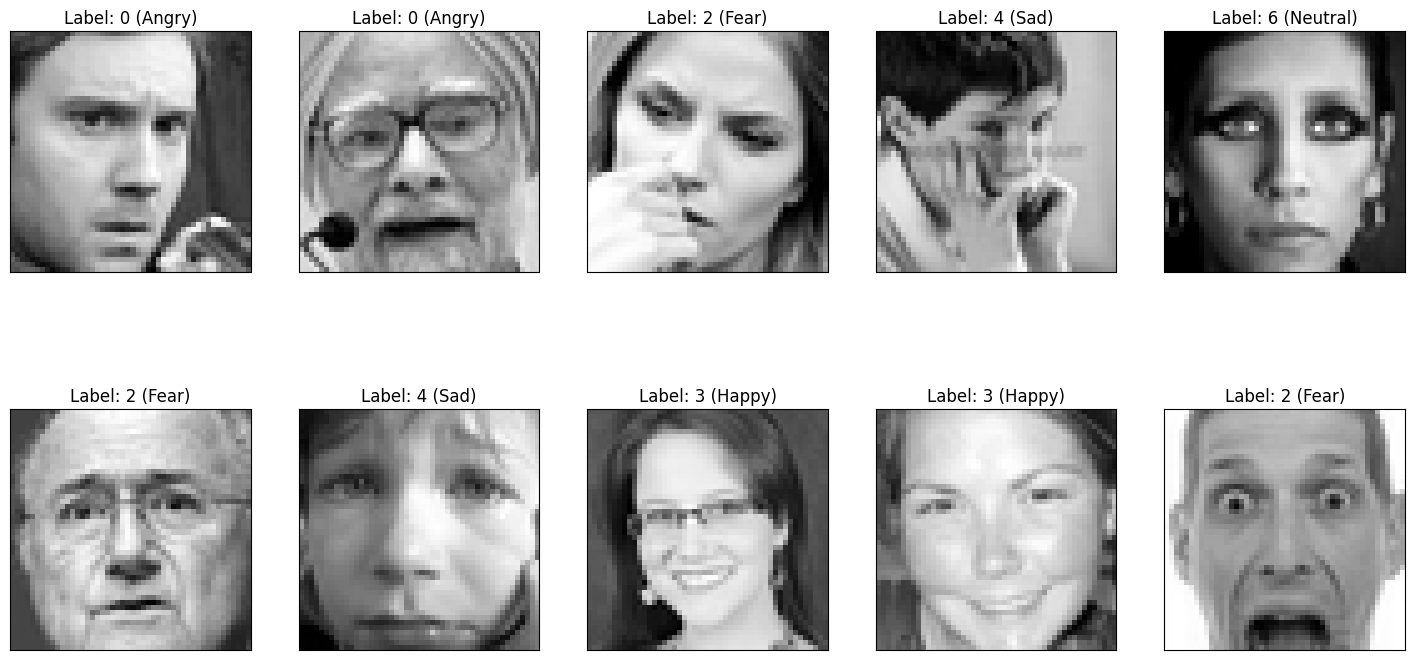

In [ ]:
## showing images here
show_img(images, labels)

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
images_tensor = torch.tensor(images, dtype=torch.float32).unsqueeze(1) / 255.0
mean = images_tensor.mean().item()
std = images_tensor.std().item()

We print the value of mean and standard have been calculated

In [ ]:
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.5073955059051514
Calculated std: 0.25512897968292236


In [ ]:
# Data Argumentation
# Định nghĩa các phép biến đổi
image_size = 48

train_transforms = transforms.Compose([
                            transforms.Resize(image_size),
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(image_size, padding=1),
                            transforms.RandomHorizontalFlip(p = 0.05), # Add this line for horizontal flip
                            transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)), # Add this line for random zoom out
                            transforms.RandomAffine(degrees=3, shear=5), # Add this line for affine transformation with shear
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

In [ ]:
# Custom Dataset
class CustomDataset(data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].numpy().astype(np.uint8).squeeze()
        image = Image.fromarray(image)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Balance the dataset
images_reshaped = images_tensor.view(images_tensor.size(0), -1).numpy()
ros = RandomOverSampler(random_state=SEED)
images_resampled, labels_resampled = ros.fit_resample(images_reshaped, labels)
images_resampled = torch.tensor(images_resampled, dtype=torch.float32).view(-1, 1, 48, 48)
labels_resampled = torch.tensor(labels_resampled)

In [ ]:
# Split the data into training and testing sets
train_size = int(0.8 * len(images))
test_size = len(images) - train_size

print(f'Number of training examples: {train_size}')
print(f'Number of testing examples: {test_size}')

Number of training examples: 28709
Number of testing examples: 7178


In [ ]:
train_indices, test_indices = torch.utils.data.random_split(range(len(images)), [train_size, test_size])

train_images = images_tensor[train_indices.indices]
train_labels = torch.tensor(labels)[train_indices.indices]

test_images = images_tensor[test_indices.indices]
test_labels = torch.tensor(labels)[test_indices.indices]

## Plot images

In [ ]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    print(rows, cols)

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(48, 48).cpu().numpy(), cmap='bone')
        ax.axis('off')

### Plot Training Images

5 5


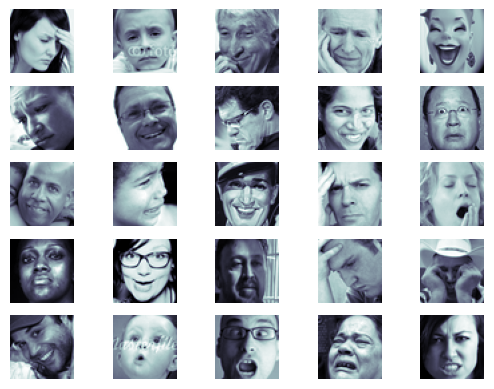

In [ ]:
N_IMAGES = 25

train_images_plot = [train_images[i] for i in range(N_IMAGES)]

plot_images(train_images_plot)

### Split Training Images into 90% for Training Images and 10% for Validation Images

In [ ]:
# Continue splitting training data into training and validation sets
VALID_RATIO = 0.9

n_train_examples = int(train_size * VALID_RATIO)
n_valid_examples = train_size - n_train_examples

In [ ]:
train_indices, valid_indices = torch.utils.data.random_split(range(len(train_images)), [n_train_examples, n_valid_examples])

valid_images = train_images[valid_indices.indices]
valid_labels = train_labels[valid_indices.indices]

train_images = train_images[train_indices.indices]
train_labels = train_labels[train_indices.indices]

### Plot Validation Images

5 5


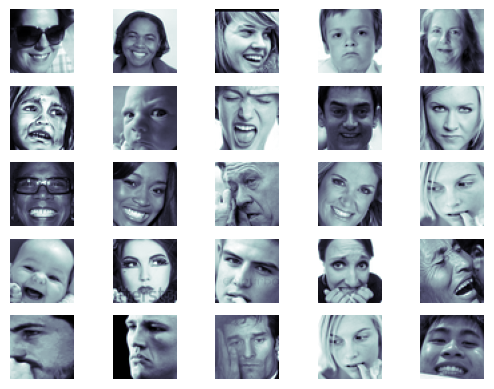

In [ ]:
N_IMAGES = 25

valid_images_plot = [valid_images[i] for i in range(N_IMAGES)]

plot_images(valid_images_plot)

In [ ]:
print(f'Number of training examples: {len(train_images)}')
print(f'Number of validation examples: {len(valid_images)}')
print(f'Number of testing examples: {len(test_images)}')

Number of training examples: 25838
Number of validation examples: 2871
Number of testing examples: 7178


In [ ]:
# Create Dataset instances
train_dataset = CustomDataset([train_images[i] for i in range(len(train_images))], [train_labels[i] for i in range(len(train_images))], transform=train_transforms)

valid_dataset = CustomDataset([valid_images[i] for i in range(len(valid_images))], [valid_labels[i] for i in range(len(valid_images))], transform=test_transforms)

test_dataset = CustomDataset([test_images[i] for i in range(len(test_images))], [test_labels[i] for i in range(len(test_images))], transform=test_transforms)

In [ ]:
# Batch Size
BATCH_SIZE = 64

# Create DataLoaders
train_loader = data.DataLoader(train_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=True)

valid_loader = data.DataLoader(valid_dataset,
                               batch_size=BATCH_SIZE)

test_loader = data.DataLoader(test_dataset,
                              batch_size=BATCH_SIZE)

### Build model with class MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 1500)
        self.hidden_fc1 = nn.Linear(1500, 750)
        self.hidden_fc2 = nn.Linear(750, 375)
        self.hidden_fc3 = nn.Linear(375, 150)
        self.hidden_fc4 = nn.Linear(150, 50)
        self.output_fc = nn.Linear(50, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]
        batch_size = x.shape[0]

        x = x.view(batch_size, -1)
        # x = [batch size, height * width]

        h_1 = F.elu(self.input_fc(x), alpha=0.1)
        # h_1 = [batch size, 1500]

        h_2 = F.elu(self.hidden_fc1(h_1), alpha=0.05)
        # h_2 = [batch size, 750]

        h_3 = F.elu(self.hidden_fc2(h_2), alpha=0.025)
        # h_3 = [batch size, 375]

        h_4 = F.elu(self.hidden_fc3(h_3), alpha=0.0125)
        # h_4 = [batch size, 150]

        h_5 = F.elu(self.hidden_fc4(h_4), alpha=0.00625)
        # h_5 = [batch size, 50]

        y_pred = self.output_fc(h_5)
        # y_pred = [batch size, output dim]
        return y_pred, h_5

In [ ]:
INPUT_DIM = 48 * 48
OUTPUT_DIM = 7

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,929,182 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Training:   0%|          | 0/404 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 0s
	Train Loss: 1.819 | Train Acc: 24.74%
	 Val. Loss: 1.821 |  Val. Acc: 24.17%


Training:   0%|          | 0/404 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 58s
	Train Loss: 1.814 | Train Acc: 25.04%
	 Val. Loss: 1.820 |  Val. Acc: 24.17%


Training:   0%|          | 0/404 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 59s
	Train Loss: 1.812 | Train Acc: 25.04%
	 Val. Loss: 1.824 |  Val. Acc: 24.17%


Training:   0%|          | 0/404 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 59s
	Train Loss: 1.812 | Train Acc: 25.05%
	 Val. Loss: 1.821 |  Val. Acc: 24.17%


Training:   0%|          | 0/404 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 1s
	Train Loss: 1.811 | Train Acc: 25.04%
	 Val. Loss: 1.822 |  Val. Acc: 24.17%


Training:   0%|          | 0/404 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 59s
	Train Loss: 1.811 | Train Acc: 25.03%
	 Val. Loss: 1.822 |  Val. Acc: 24.17%


Training:   0%|          | 0/404 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 0s
	Train Loss: 1.812 | Train Acc: 24.96%
	 Val. Loss: 1.824 |  Val. Acc: 24.17%


Training:   0%|          | 0/404 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 15s
	Train Loss: 1.811 | Train Acc: 25.04%
	 Val. Loss: 1.823 |  Val. Acc: 24.17%


Training:   0%|          | 0/404 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 20s
	Train Loss: 1.811 | Train Acc: 25.05%
	 Val. Loss: 1.820 |  Val. Acc: 24.17%


Training:   0%|          | 0/404 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 18s
	Train Loss: 1.811 | Train Acc: 25.04%
	 Val. Loss: 1.820 |  Val. Acc: 24.17%


In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, device)

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

In [ ]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.811 | Test Acc: 25.28%


In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_loader, device)

pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(7))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

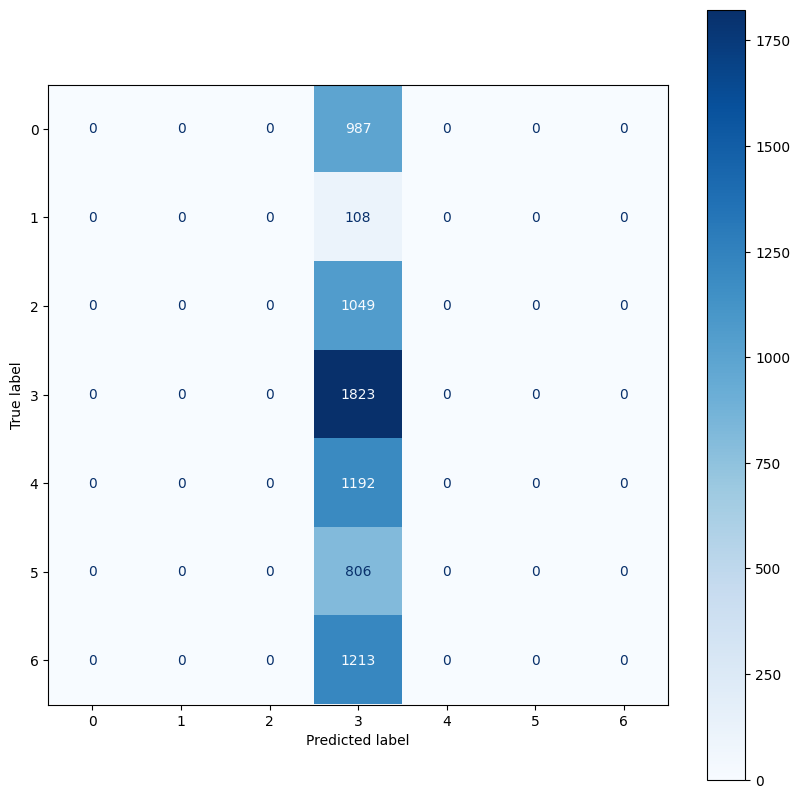

In [ ]:
plot_confusion_matrix(labels, pred_labels)

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [ ]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(48, 48).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

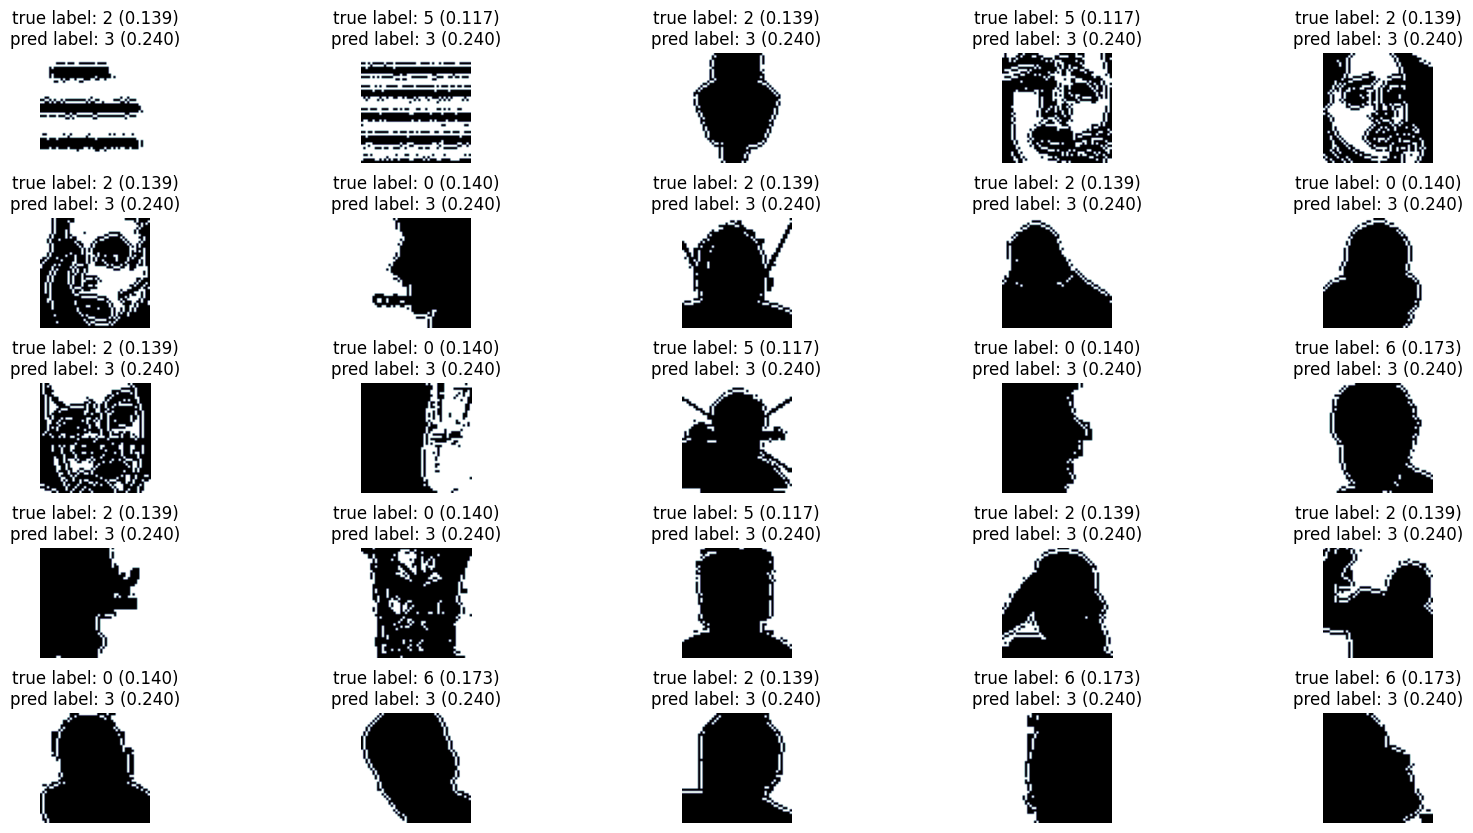

In [ ]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

### PCA

In [ ]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [ ]:
outputs, intermediates, labels = get_representations(model,
                                                     train_loader,
                                                     device)

  0%|          | 0/404 [00:00<?, ?it/s]

In [ ]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [ ]:
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

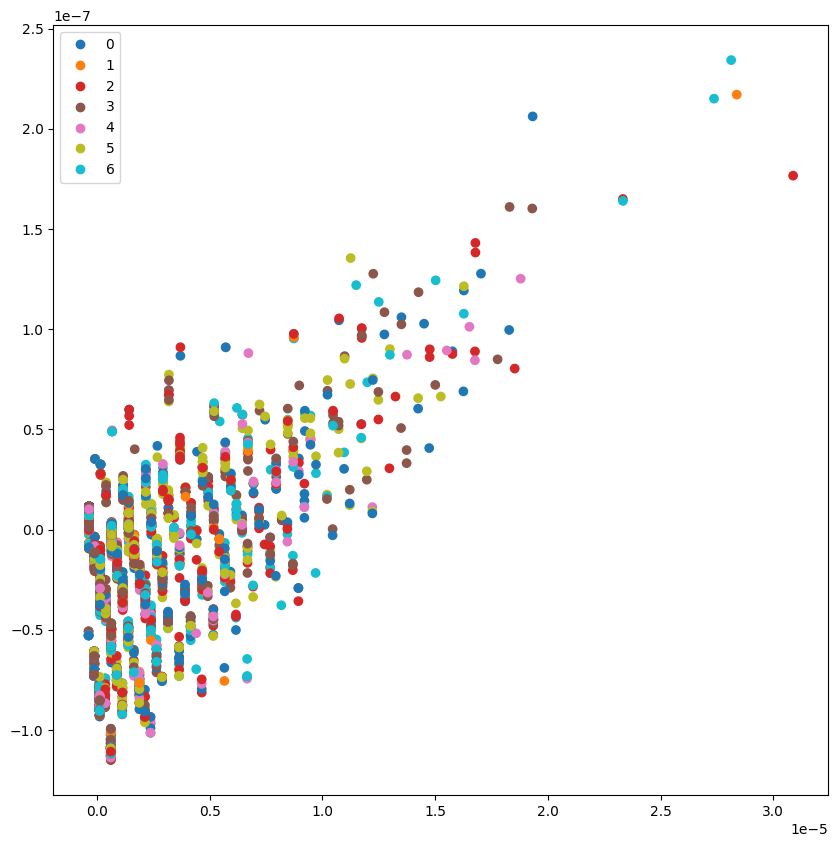

In [ ]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)

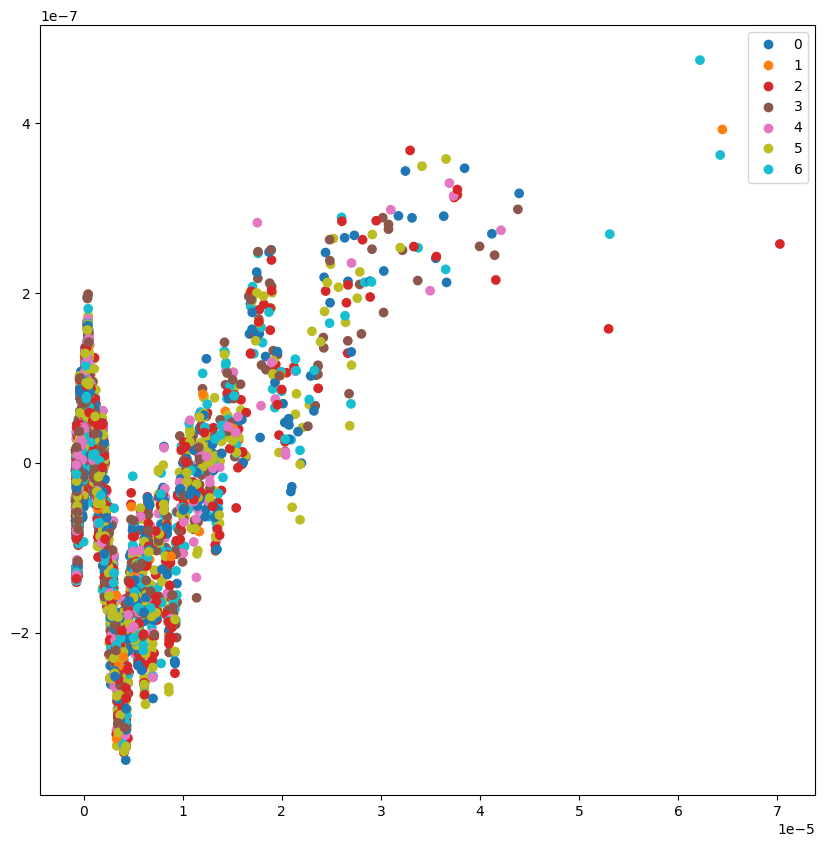

In [ ]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

In [ ]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

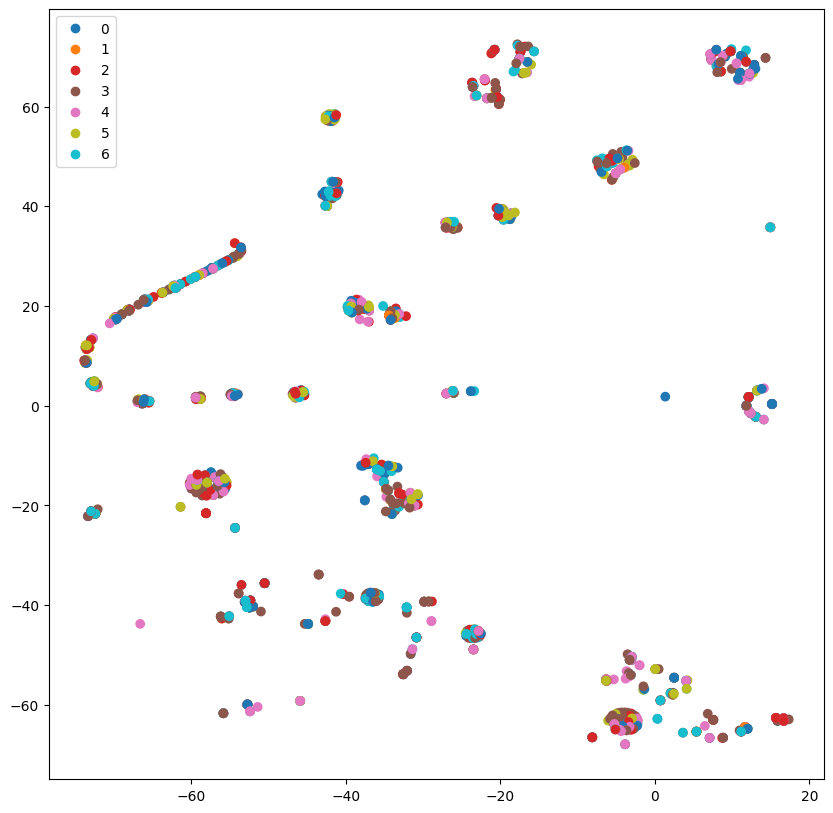

In [ ]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)

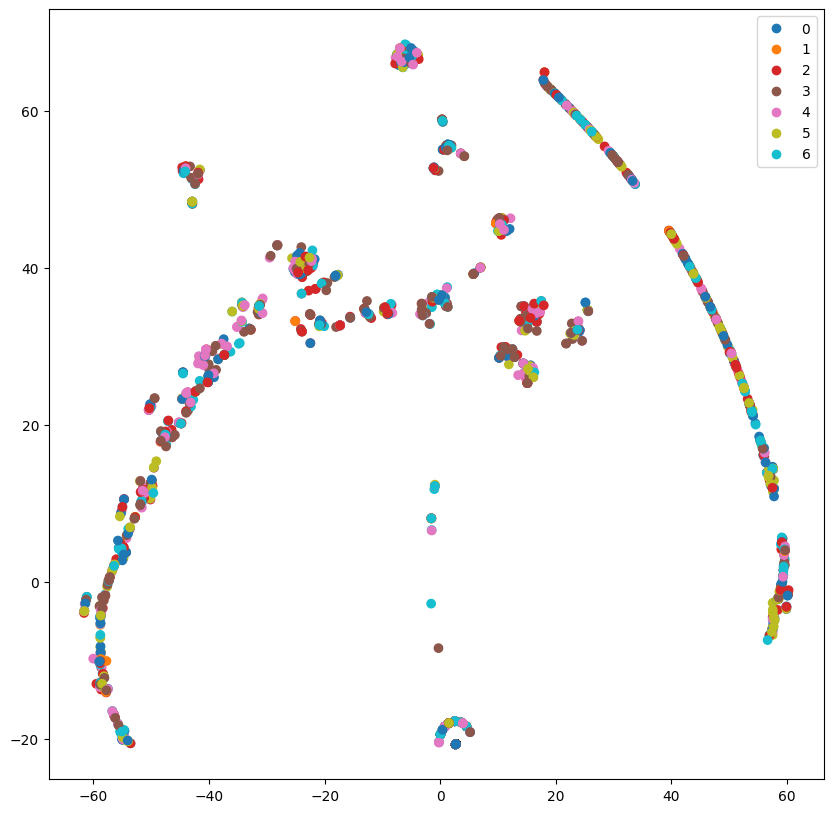

In [ ]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)